In [1]:
# IMDb Movie Review Sentiment Analysis
# Part A: Complete Implementation

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Download necessary NLTK resources
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [5]:
# Data loading and exploration
data = pd.read_csv("imbd.csv")
data = data[["review", "sentiment"]].dropna()
data = data[["review", "sentiment"]]
df = pd.DataFrame(data, columns=['review', 'sentiment'])
print("\nDataset Sample:")
print(data.head())


Dataset Sample:
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [6]:
# Basic data exploration
print("\nDataset shape:", df.shape)
print("\nSentiment distribution:")
print(df['sentiment'].value_counts())


Dataset shape: (50000, 2)

Sentiment distribution:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


In [7]:
# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())


Missing values:
review       0
sentiment    0
dtype: int64



Review length statistics:
count    50000.000000
mean      1309.367720
std        989.759532
min          7.000000
25%        699.000000
50%        970.000000
75%       1590.000000
max      13704.000000
Name: review_length, dtype: float64
Saved: review_length_distribution.png


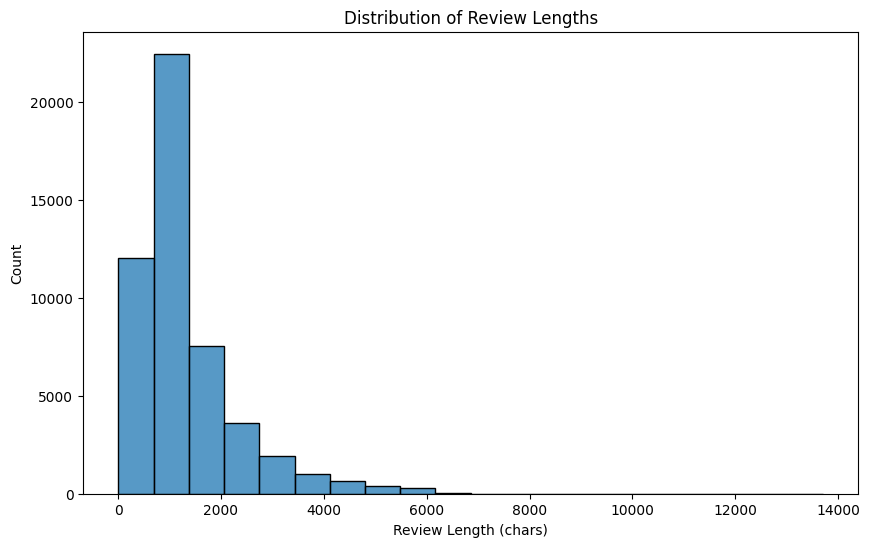

In [8]:
# Analyze review lengths
df['review_length'] = df['review'].apply(len)
print("\nReview length statistics:")
print(df['review_length'].describe())
plt.figure(figsize=(10, 6))
sns.histplot(df['review_length'], bins=20)
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length (chars)')
plt.ylabel('Count')
plt.savefig('review_length_distribution.png')
print("Saved: review_length_distribution.png")

Text(0, 0.5, 'Count')

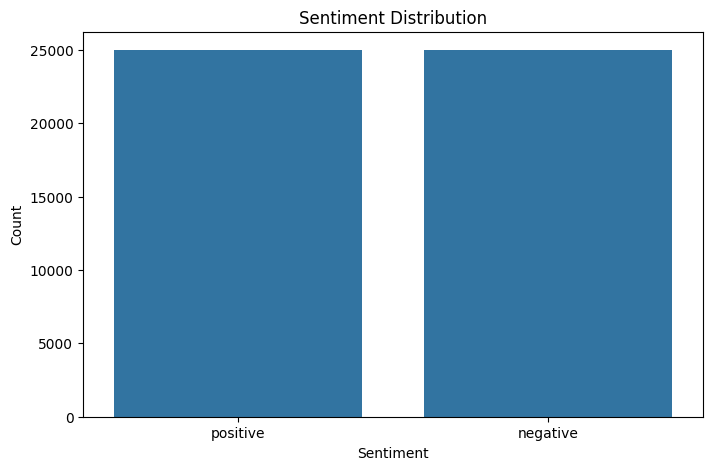

In [9]:
# Sentiment distribution visualization
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='sentiment', data=df)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')


In [10]:
# Add count labels
for p in ax.patches:
  ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.savefig('sentiment_distribution.png')
print("Saved: sentiment_distribution.png")



Saved: sentiment_distribution.png


<Figure size 640x480 with 0 Axes>

In [11]:
def preprocess_text(text):

  # Remove HTML tags
  text = re.sub(r'<.*?>', ' ', text)

  # Remove punctuation
  text = text.translate(str.maketrans('', '', string.punctuation))

  # Convert to lowercase
  text = text.lower()

  # Tokenize
  tokens = word_tokenize(text)

  # Remove stopwords
  stop_words = set(stopwords.words('english'))
  tokens = [word for word in tokens if word not in stop_words]

  # Lemmatization
  lemmatizer = WordNetLemmatizer()
  tokens = [lemmatizer.lemmatize(word) for word in tokens]

  # Join tokens back to text
  preprocessed_text = ' '.join(tokens)

  return preprocessed_text
df['preprocessed_review'] = df['review'].apply(preprocess_text)

print("Sample of preprocessed reviews:")
for i in range(min(3, len(df))):
  print(f"\nOriginal review {i+1}:")
  print(df['review'][i][:200] + "...")
  print(f"\nPreprocessed review {i+1}:")
  print(df['preprocessed_review'][i][:200] + "...")

Sample of preprocessed reviews:

Original review 1:
One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me abo...

Preprocessed review 1:
one reviewer mentioned watching 1 oz episode youll hooked right exactly happened first thing struck oz brutality unflinching scene violence set right word go trust show faint hearted timid show pull p...

Original review 2:
A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece...

Preprocessed review 2:
wonderful little production filming technique unassuming oldtimebbc fashion give comforting sometimes discomforting sense realism entire piece actor extremely well chosen michael sheen got polari voic...

Original review 3:
I thought this was a wonderful way to spend 

In [12]:
# Generate word clouds for positive and negative reviews
positive_text = ' '.join(df[df['sentiment'] == 'positive']['preprocessed_review'])
negative_text = ' '.join(df[df['sentiment'] == 'negative']['preprocessed_review'])


In [13]:
#3 task3
# Calculate text features
df['word_count'] = df['preprocessed_review'].apply(lambda x: len(x.split()))
df['char_count'] = df['preprocessed_review'].apply(len)
df['avg_word_length'] = df['char_count'] / df['word_count']

In [14]:
print("\nText Features:")
print(df[['word_count', 'char_count', 'avg_word_length']].describe())


Text Features:
         word_count    char_count  avg_word_length
count  50000.000000  50000.000000     50000.000000
mean     120.277820    820.855140         6.771536
std       90.482432    633.059195         0.457216
min        1.000000      5.000000         4.866667
25%       65.000000    430.000000         6.465649
50%       89.000000    604.000000         6.759036
75%      146.000000    997.000000         7.060999
max     1437.000000   9213.000000        17.617647


Saved: word_count_by_sentiment.png


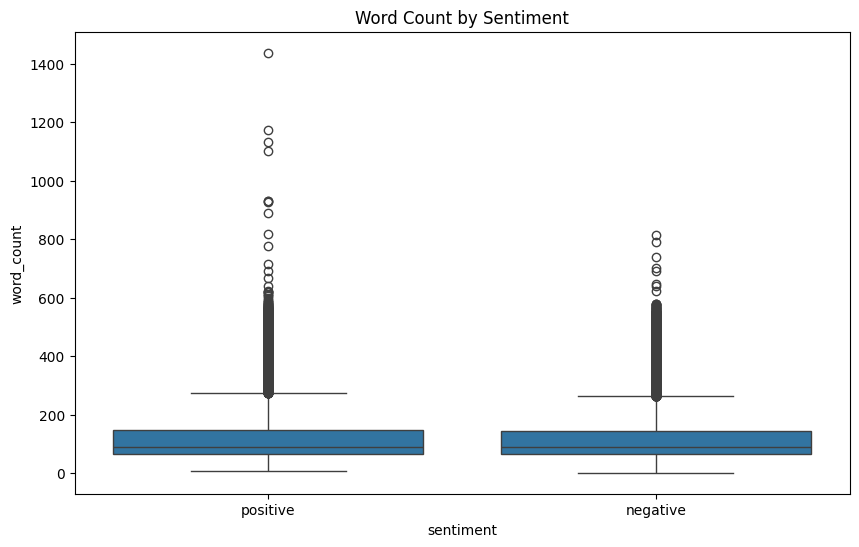

In [15]:
# Visualize relationships between features and sentiment
plt.figure(figsize=(10, 6))
sns.boxplot(x='sentiment', y='word_count', data=df)
plt.title('Word Count by Sentiment')
plt.savefig('word_count_by_sentiment.png')
print("Saved: word_count_by_sentiment.png")


Saved: avg_word_length_by_sentiment.png


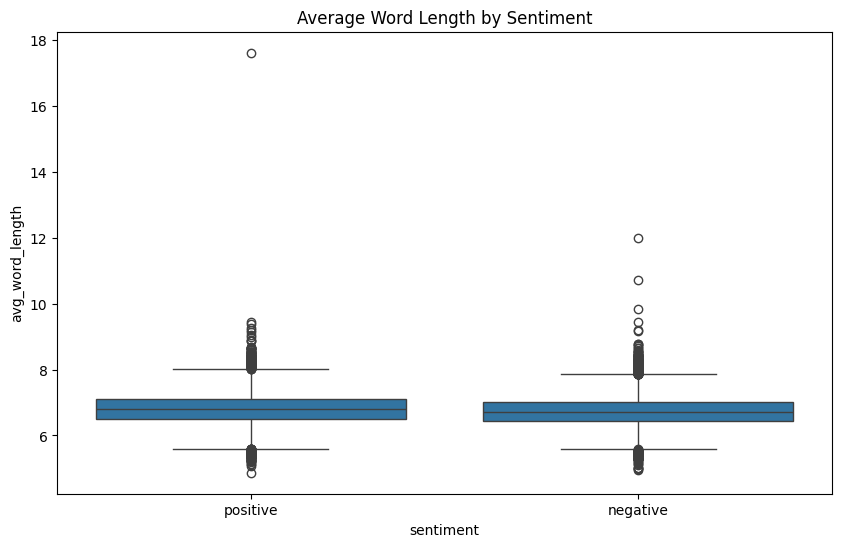

In [16]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='sentiment', y='avg_word_length', data=df)
plt.title('Average Word Length by Sentiment')
plt.savefig('avg_word_length_by_sentiment.png')
print("Saved: avg_word_length_by_sentiment.png")

In [17]:
# Feature extraction with TF-IDF
print("\nPerforming TF-IDF vectorization...")
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(df['preprocessed_review'])
print(f"TF-IDF feature shape: {X_tfidf.shape}")

# Feature extraction with Bag of Words (CountVectorizer)
print("\nPerforming Bag of Words vectorization...")
count_vectorizer = CountVectorizer(max_features=5000)
X_bow = count_vectorizer.fit_transform(df['preprocessed_review'])
print(f"Bag of Words feature shape: {X_bow.shape}")


Performing TF-IDF vectorization...
TF-IDF feature shape: (50000, 5000)

Performing Bag of Words vectorization...
Bag of Words feature shape: (50000, 5000)


In [18]:
# Create a feature set with both TF-IDF features and additional text features
# Convert sentiment to binary (0/1)
df['sentiment_binary'] = df['sentiment'].map({'positive': 1, 'negative': 0})
# Create target variable
y = df['sentiment_binary'].values

In [19]:
# 4. Model Development
# Split the data into training and testing sets
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(
X_tfidf, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train_tfidf.shape}")
print(f"Testing set size: {X_test_tfidf.shape}")

Training set size: (40000, 5000)
Testing set size: (10000, 5000)


In [20]:
# Train multiple models and compare their performance
models = {
'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
'Naive Bayes': MultinomialNB(),
'Support Vector Machine': LinearSVC(random_state=42),
'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}


In [21]:
# Dictionary to store model results
model_results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)


Training Logistic Regression...

Training Naive Bayes...

Training Support Vector Machine...

Training Random Forest...


In [22]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"{name} performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Random Forest performance:
Accuracy: 0.8574
Precision: 0.8655
Recall: 0.8490
F1 Score: 0.8571


Saved: confusion_matrix_random_forest.png


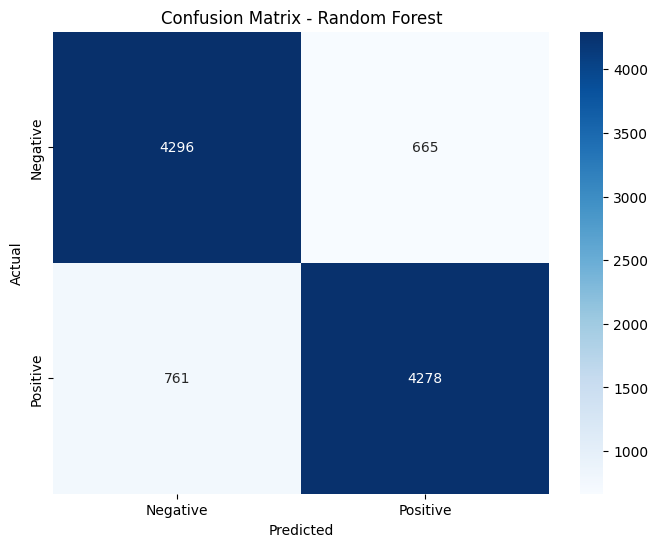

In [23]:
# Store results
model_results[name] = {
'accuracy': accuracy,
'precision': precision,
'recall': recall,
'f1': f1
}

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
xticklabels=['Negative', 'Positive'],
yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - {name}')
plt.savefig(f'confusion_matrix_{name.replace(" ", "_").lower()}.png')
print(f"Saved: confusion_matrix_{name.replace(' ', '_').lower()}.png")


PART 5: MODEL EVALUATION AND COMPARISON

Model Performance Comparison:
               accuracy  precision    recall        f1
Random Forest    0.8574   0.865466  0.848978  0.857143
Saved: model_comparison.png


<Figure size 1200x800 with 0 Axes>

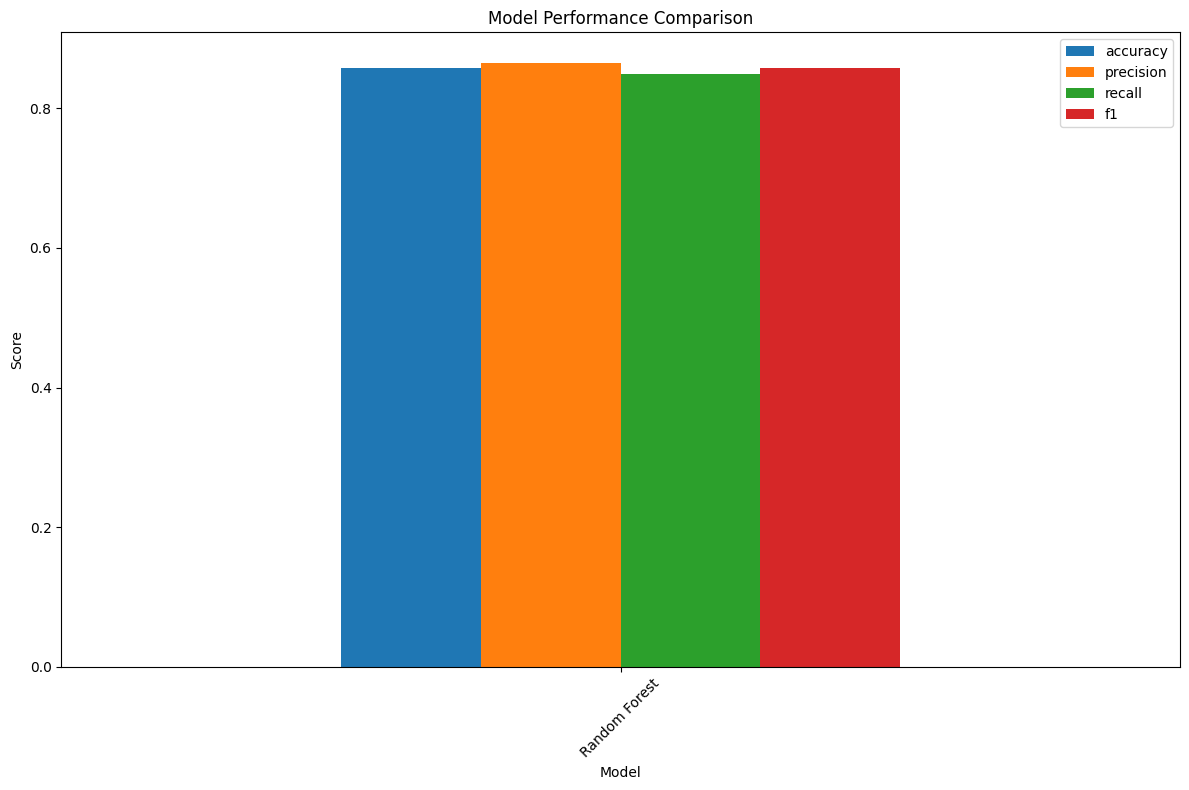

In [24]:

# 5. Model Evaluation and Comparison
# Create DataFrame with model results for easy comparison
results_df = pd.DataFrame(model_results).T
print("\nModel Performance Comparison:")
print(results_df)

# Visualize model comparison
plt.figure(figsize=(12, 8))
results_df.plot(kind='bar', figsize=(12, 8))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('model_comparison.png')
print("Saved: model_comparison.png")

In [25]:
# Find the best model based on F1 score
best_model_name = results_df['f1'].idxmax()
best_model = models[best_model_name]
print(f"\nBest performing model: {best_model_name} with F1 Score of {results_df.loc[best_model_name, 'f1']:.4f}")


Best performing model: Random Forest with F1 Score of 0.8571



Performing hyperparameter tuning for the best model...
Best parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Best cross-validation score: 0.8509

Tuned model performance:
Accuracy: 0.8580
Precision: 0.8615
Recall: 0.8557
F1 Score: 0.8586
Saved: confusion_matrix_tuned_model.png


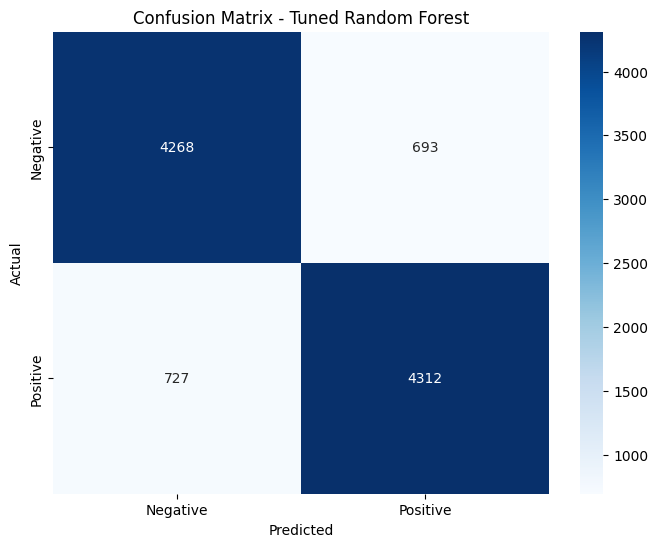

In [27]:
# Hyperparameter tuning for the best model
print("\nPerforming hyperparameter tuning for the best model...")

if best_model_name == 'Logistic Regression':
    param_grid = {
    'C': [0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs']
    }
elif best_model_name == 'Naive Bayes':
    param_grid = {
    'alpha': [0.1, 0.5, 1.0, 2.0]
    }
elif best_model_name == 'Support Vector Machine':
    param_grid = {
    'C': [0.1, 1, 10],
    'loss': ['hinge', 'squared_hinge']
    }

else: # Random Forest
    param_grid = {
   'n_estimators': [100, 200],
    'max_depth': [10, None],
    'min_samples_split': [2, 5]
    }


grid_search = GridSearchCV(best_model, param_grid, cv=3, scoring='f1', n_jobs= -1)
grid_search.fit(X_train_tfidf, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Evaluate the tuned model
tuned_model = grid_search.best_estimator_
y_pred_tuned = tuned_model.predict(X_test_tfidf)

accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
precision_tuned = precision_score(y_test, y_pred_tuned)
recall_tuned = recall_score(y_test, y_pred_tuned)
f1_tuned = f1_score(y_test, y_pred_tuned)

print("\nTuned model performance:")
print(f"Accuracy: {accuracy_tuned:.4f}")
print(f"Precision: {precision_tuned:.4f}")
print(f"Recall: {recall_tuned:.4f}")
print(f"F1 Score: {f1_tuned:.4f}")

# Generate confusion matrix for tuned model
cm_tuned = confusion_matrix(y_test, y_pred_tuned)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Blues',
xticklabels=['Negative', 'Positive'],
yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - Tuned {best_model_name}')
plt.savefig('confusion_matrix_tuned_model.png')
print("Saved: confusion_matrix_tuned_model.png")

In [30]:
# 6. Prediction on new reviews
new_reviews = [
"This movie was absolutely fantastic! The acting was superb and the storyline kept me engaged throughout.",
"What a waste of time. The plot was confusing and the characters were poorly developed."
]

print("\nPredicting sentiment for new reviews:")

# Preprocess new reviews
preprocessed_new_reviews = [preprocess_text(review) for review in new_reviews]

# Vectorize new reviews
new_reviews_tfidf = tfidf_vectorizer.transform(preprocessed_new_reviews)

# Predict sentiment
predictions = tuned_model.predict(new_reviews_tfidf)

for i, review in enumerate(new_reviews):
  sentiment = "Positive" if predictions[i] == 1 else "Negative"
print(f"\nReview: {review}")
print(f"Predicted sentiment: {sentiment}")


Predicting sentiment for new reviews:

Review: What a waste of time. The plot was confusing and the characters were poorly developed.
Predicted sentiment: Negative
